# RNN (Rekurrent Neyron Şəbəkələri) ilə Temperatur Proqnozlaşdırma

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

## Sintetik temperatur verilənlərini yaradırıq

In [2]:

dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
temp_base = np.sin(np.arange(len(dates)) * (2 * np.pi / 365)) * 10 + 20  # İllik temperatur dəyişməsi
random_variation = np.random.normal(0, 2, len(dates))  # Təsadüfi variasiyalar
temperatures = temp_base + random_variation

df = pd.DataFrame({'date': dates, 'temperature': temperatures})
print("Verilənlər yükləndi. İlk 5 sətir:")
df.head()

Verilənlər yükləndi. İlk 5 sətir:


,date,temperature
0,2023-01-01,20.993428
1,2023-01-02,19.895605
2,2023-01-03,21.639593
3,2023-01-04,23.562256
4,2023-01-05,20.219718


## Verilənləri vizuallaşdırırıq

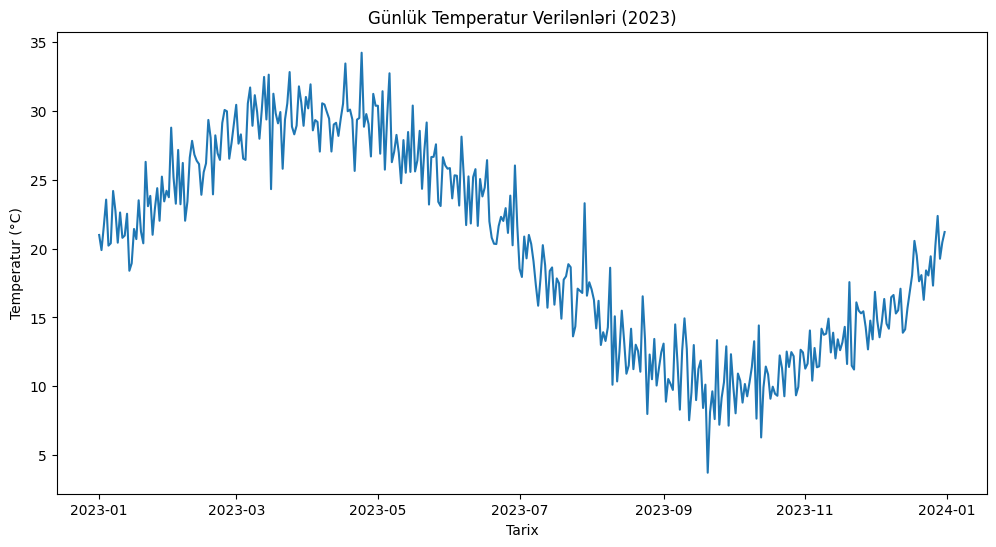

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temperature'])
plt.title('Günlük Temperatur Verilənləri (2023)')
plt.xlabel('Tarix')
plt.ylabel('Temperatur (°C)')
plt.show()

## Verilənləri hazırlayırıq

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['temperature'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"Train verilənlərinin ölçüsü: {train_data.shape}")
print(f"Test verilənlərinin ölçüsü: {test_data.shape}")

Train verilənlərinin ölçüsü: (292, 1)
Test verilənlərinin ölçüsü: (73, 1)


## RNN üçün verilənləri hazırlayırıq

In [5]:
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Train verilənlərinin forması: {X_train.shape}")
print(f"Test verilənlərinin forması: {X_test.shape}")

Train verilənlərinin forması: (232, 60, 1)
Test verilənlərinin forması: (13, 60, 1)


## LSTM modelini yaradırıq

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
print("Model yaradıldı və kompilyasiya edildi:")
model.summary()



Model yaradıldı və kompilyasiya edildi:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Modeli öyrədirik

In [7]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Model öyrədilir...
Epoch 1/20

7/7 [==============================] - 5s 190ms/step - loss: 0.2963 - val_loss: 0.0047
Epoch 2/20
7/7 [==============================] - 0s 43ms/step - loss: 0.0360 - val_loss: 0.0153
Epoch 3/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0148 - val_loss: 0.0041
Epoch 4/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0169 - val_loss: 0.0069
Epoch 5/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 6/20
7/7 [==============================] - 0s 44ms/step - loss: 0.0089 - val_loss: 0.0049
Epoch 7/20
7/7 [==============================] - 0s 44ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 8/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 10/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 11

## Öyrənmə prosesini vizuallaşdırırıq

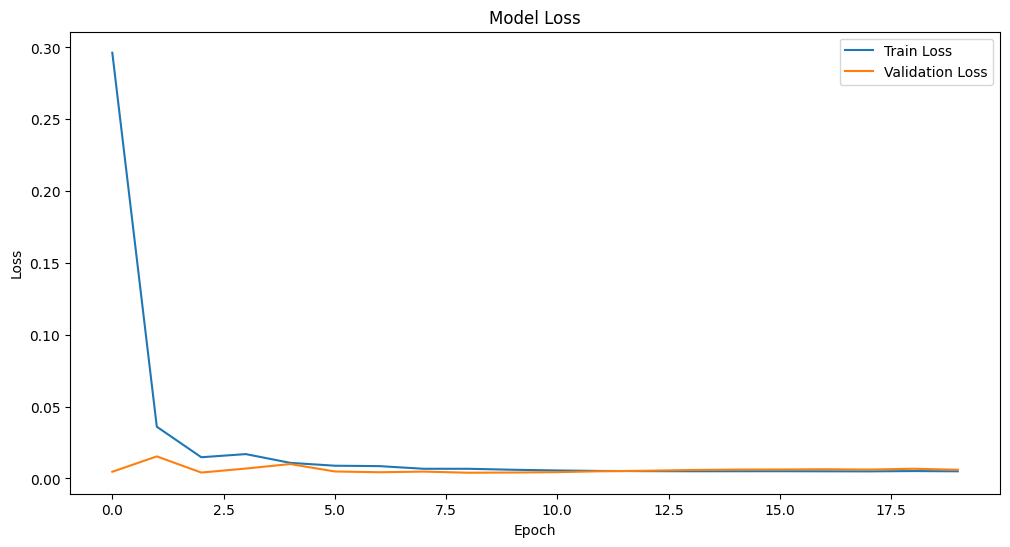

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test verilənləri üzərində proqnozlar edirik

In [9]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted) 

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 [==============================] - 1s 1s/step


## Nəticələri vizuallaşdırırıq

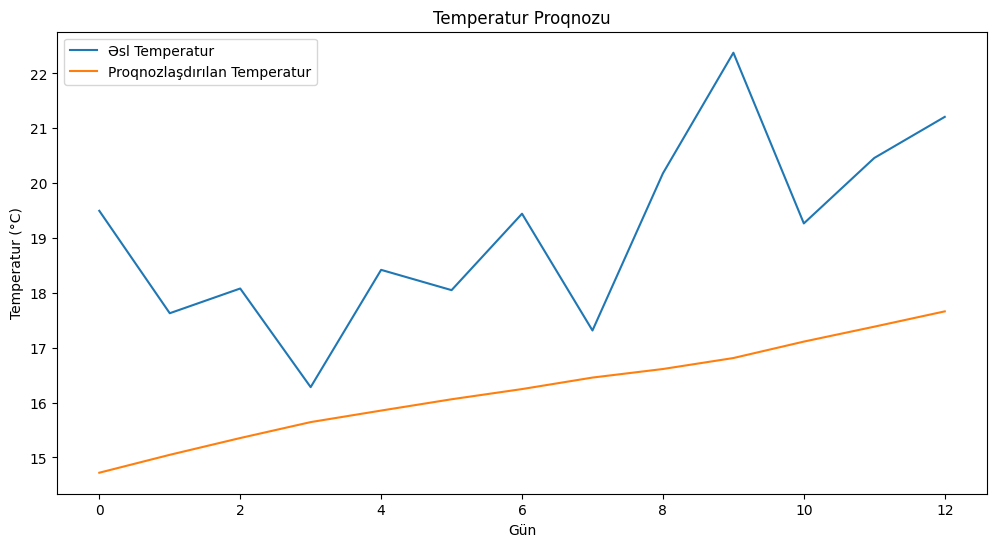

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Əsl Temperatur')
plt.plot(predicted, label='Proqnozlaşdırılan Temperatur')
plt.title('Temperatur Proqnozu')
plt.xlabel('Gün')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.show()

## Modelin dəqiqliyini hesablayırıq

In [11]:
mse = np.mean((predicted - y_test_actual) ** 2)
rmse = np.sqrt(mse)
print(f"Orta kvadrat xəta (MSE): {mse:.4f}")
print(f"Kök orta kvadrat xəta (RMSE): {rmse:.4f}")

Orta kvadrat xəta (MSE): 9.9327
Kök orta kvadrat xəta (RMSE): 3.1516


## Gələcək 30 gün üçün proqnoz

In [12]:
last_60_days = scaled_data[-60:].reshape(1, 60, 1)
future_predictions = []

for _ in range(30):
    next_day_pred = model.predict(last_60_days, verbose=0)
    future_predictions.append(next_day_pred[0, 0])
    next_val = np.array([[[next_day_pred[0, 0]]]])
    last_60_days = np.concatenate((last_60_days[:, 1:, :], next_val), axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=30, freq='D')

## Gələcək proqnozları fluktuasiyalarla vizuallaşdırırıq

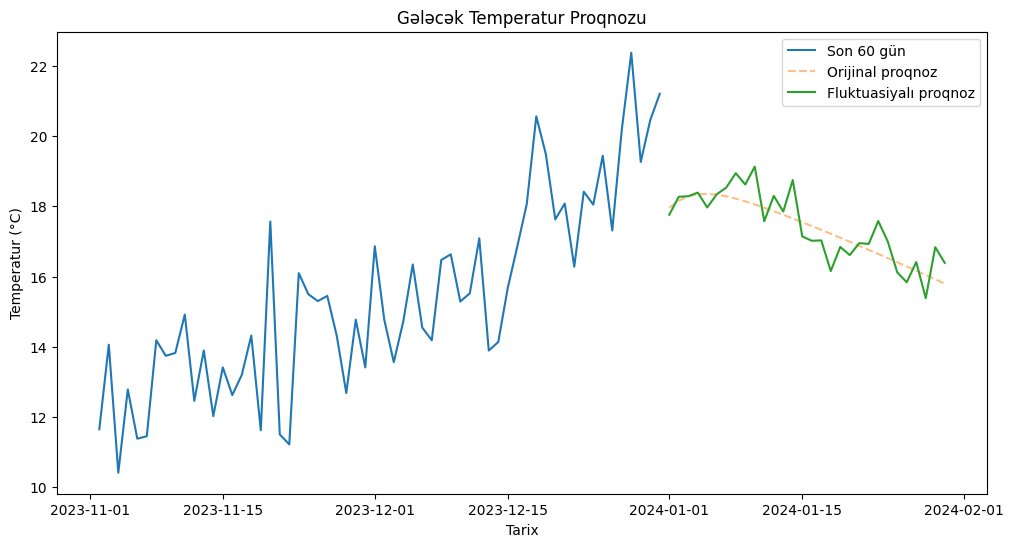

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(dates[-60:], df['temperature'].values[-60:], label='Son 60 gün')

fluctuation_scale = 0.5  # 0.5°C təsadüfi fluktuasiya
random_fluctuations = np.random.normal(0, fluctuation_scale, size=future_predictions.shape)
natural_predictions = future_predictions + random_fluctuations

plt.plot(future_dates, future_predictions, '--', alpha=0.5, label='Orijinal proqnoz')
plt.plot(future_dates, natural_predictions, label='Fluktuasiyalı proqnoz')

plt.title('Gələcək Temperatur Proqnozu')
plt.xlabel('Tarix')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.show()

## Proqnozlaşdırılan temperaturları göstəririk

In [14]:
print("\nNövbəti 30 gün üçün temperatur proqnozu:")
forecast_df = pd.DataFrame({
    'Tarix': future_dates, 
    'Orijinal Proqnoz (°C)': future_predictions.flatten(),
    'Fluktuasiyalı Proqnoz (°C)': natural_predictions.flatten()
})
forecast_df


Növbəti 30 gün üçün temperatur proqnozu:


,Tarix,Orijinal Proqnoz (°C),Fluktuasiyalı Proqnoz (°C)
0,2024-01-01,17.961245,17.760634
1,2024-01-02,18.161270,18.273316
2,2024-01-03,18.283218,18.289515
3,2024-01-04,18.343140,18.391978
4,2024-01-05,18.355841,17.969336
5,2024-01-06,18.333601,18.345856
6,2024-01-07,18.286053,18.535052
7,2024-01-08,18.220434,18.946006
8,2024-01-09,18.142008,18.621643
9,2024-01-10,18.054525,19.131117
